In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform
from PIL import Image
import numpy as np
import imageio
import glob

In [7]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Done processing 0 images.
Done processing 5 images.
Done processing 10 images.
Done processing 15 images.
Done processing 20 images.
Done processing 25 images.
Done processing 30 images.
Done processing 35 images.
Done processing 40 images.
Done processing 45 images.
Done processing 50 images.
Done processing 55 images.
Done processing 60 images.
Done processing 65 images.
Done processing 70 images.
Done processing 75 images.
Done processing 80 images.
Done processing 85 images.
Done processing 90 images.
Done processing 95 images.
Done processing 100 images.
Done processing 105 images.
Done processing 110 images.
Done processing 115 images.
Done processing 120 images.
Done processing 125 images.
Done processing 130 images.
Done processing 135 images.
Done processing 140 images.
Done processing 145 images.
Done processing 150 images.
Done processing 155 images.
Done processing 160 images.
Done processing 165 images.
Done processing 170 images.
Done processing 175 images.
Done processin

NameError: name 'rect_true1' is not defined

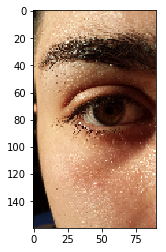

In [20]:
def load_pics():
    
    pics = glob.glob('SamsungGalaxyS4/*.jpg', recursive=True)

    X = []
    names = []
    sizes = []
    for idx, pic in enumerate(pics):
        f = imageio.imread(pic)/255.0
        sizes.append(f.shape[0])
        f = skimage.transform.resize(f, (160,90))
        X.append(f)
        names.append(pic[-24:-4])
        if idx % 20 == 0:
            print('Done processing %d images.' % idx)
    
    X = np.array(X)
    return X, names, sizes

#load annotations
def load_annotations(X, order, sizes):
    N = X.shape[0]
    f = open('micheI_sgs4.txt')
    y_trunc = np.zeros((N, 3)) 
    y_true = np.zeros((N,3))
    for l in f:
        l = l.strip().split(' ')
        name, a, b, c = l[0], int(l[1]), int(l[2]), int(l[3])
        i = order.index(name)
        resize_factor = int(sizes[i]/160.0)
        y_true[i] += np.array([a, b, c])
        y_trunc[i] += np.array([a // resize_factor, b // resize_factor, c // resize_factor])
    return y_true, y_trunc

In [ ]:
X, order, sizes = load_pics()
Xt = np.array(X).reshape((X.shape[0], 1, 3, X.shape[1], X.shape[2]))
y_true, y = load_annotations(X, order, sizes)

(57.0, 75.0, 12.0)


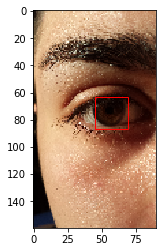

(46.0, 56.0, 8.0)


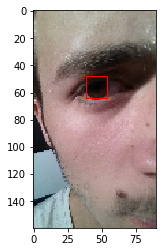

(67.0, 80.0, 12.0)


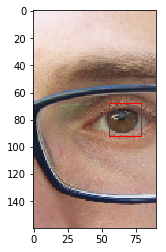

(45.0, 71.0, 8.0)


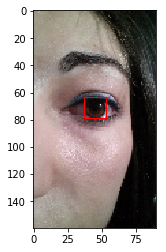

In [25]:
fig, ax = plt.subplots(1)
plt.imshow(Xt[0,0,:,:,:].reshape(160,90,3))
xc, yc, r = y[0]
print((xc, yc, r))
rect_true1 = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect_true1)
plt.show()

fig, ax = plt.subplots(1)
plt.imshow(Xt[20,0,:,:,:].reshape(160,90,3))
xc, yc, r = y[20]
print((xc, yc, r))
rect_true2 = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect_true2)
plt.show()

fig, ax = plt.subplots(1)
plt.imshow(Xt[400,0,:,:,:].reshape(160,90,3))
xc, yc, r = y[400]
print((xc, yc, r))
rect_true3 = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect_true3)
plt.show()

fig, ax = plt.subplots(1)
plt.imshow(Xt[900,0,:,:,:].reshape(160,90,3))
xc, yc, r = y[900]
print((xc, yc, r))
rect_true4 = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect_true4)
plt.show()

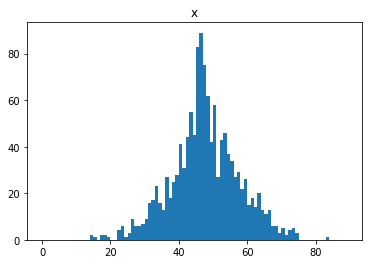

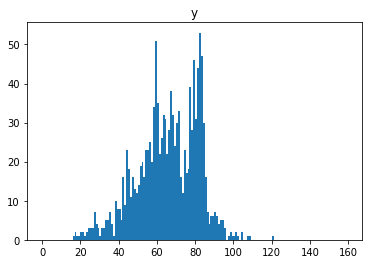

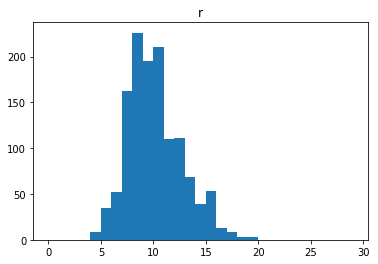

(1297, 1, 3, 160, 90)
(1297, 3, 1)


In [29]:
plt.hist(y[:,0], bins=range(90))
plt.title('x')
plt.show()

plt.hist(y[:,1], bins=range(160))
plt.title('y')
plt.show()

plt.hist(y[:,2], bins=range(30))
plt.title('r')
plt.show()

yt = y.reshape((y.shape[0], y.shape[1], 1))

print(Xt.shape)
print(yt.shape)

In [30]:
N = Xt.shape[0]
train = int(6*N/10)
val = int(7*N/10)
X_train = Xt[:train]
X_val = Xt[train:val]
X_test = Xt[val:]

y_train = yt[:train]
y_train_true = y_true[:train]

y_val = yt[train:val]
y_val_true = y_true[train:val]

y_test = yt[val:]
y_test_true = y_true[val:]

X_train = torch.tensor(X_train).type(torch.FloatTensor)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val).type(torch.FloatTensor)
y_val = torch.tensor(y_val)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

torch.Size([778, 1, 3, 160, 90])
torch.Size([778, 3, 1])
torch.Size([129, 1, 3, 160, 90])
torch.Size([129, 3, 1])


In [31]:
def check_accuracy_part34(mode, model, param):
    
    def assign_param(param, y_generic):
        if param == 'x':
            return y_generic[:,0]
        elif param == 'y':
            return y_generic[:,1]
        else:
            return y_generic[:,2]
    
    if mode == 'val':
        X_sel = X_val
        y_sel = assign_param(param, y_val)
    elif mode == 'train':
        X_sel = X_train
        y_sel = assign_param(param, y_train)
    else:
        X_sel = X_test
        y_sel = assign_param(param, y_test)
        
    SE = 0.0
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #SE += (x_center.data[0][0] - y) ** 2
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))
        #print(('RMSE ->', SE))

In [35]:
def train_part34(model, optimizer, param, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    if param == 'x':
        y_sel = y_train[:,0]
    elif param == 'y':
        y_sel = y_train[:,1]
    else:
        y_sel = y_train[:,2]
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #for t, (x, y) in enumerate(training_data):
        for t in range(X_train.shape[0]):
            model.train()  # put model to training mode
            
            x = X_train[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #loss = F.mse_loss(x_center[0][0], y)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model, param)
        check_accuracy_part34('val', model, param)
        print() 

In [32]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [33]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [43]:
channel_1 = 32
channel_2 = 16

model_x = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(13104, 672),
    nn.ReLU(),
    nn.Linear(672, 90)
)

model_y = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(13104, 672),
    nn.ReLU(),
    nn.Linear(672, 160)
)

model_r = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(13104, 672),
    nn.ReLU(),
    nn.Linear(672, 45)
)

optimizer_x = optim.SGD(model_x.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer_y = optim.SGD(model_y.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer_r = optim.SGD(model_r.parameters(), lr=1e-4, momentum=0.9, nesterov=True)

In [40]:
print('Train X Position')
train_part34(model_x, optimizer_x, 'x', epochs=50)

Train X Position
Iteration 0, loss = 4.5226

Iteration 500, loss = 2.7000

epoch 0
Got 49 / 778 correct (6.30) for mode train
Got 10 / 129 correct (7.75) for mode val

Iteration 0, loss = 4.0742

Iteration 500, loss = 2.7733

epoch 1
Got 51 / 778 correct (6.56) for mode train
Got 6 / 129 correct (4.65) for mode val

Iteration 0, loss = 3.9612

Iteration 500, loss = 2.8206

epoch 2
Got 39 / 778 correct (5.01) for mode train
Got 6 / 129 correct (4.65) for mode val

Iteration 0, loss = 3.8794

Iteration 500, loss = 2.8376

epoch 3
Got 39 / 778 correct (5.01) for mode train
Got 6 / 129 correct (4.65) for mode val

Iteration 0, loss = 3.8406

Iteration 500, loss = 2.8496

epoch 4
Got 39 / 778 correct (5.01) for mode train
Got 6 / 129 correct (4.65) for mode val

Iteration 0, loss = 3.8082

Iteration 500, loss = 2.8657

epoch 5
Got 39 / 778 correct (5.01) for mode train
Got 6 / 129 correct (4.65) for mode val

Iteration 0, loss = 3.7763

Iteration 500, loss = 2.8762

epoch 6
Got 41 / 778 cor

In [44]:
print('Train Y Position')
train_part34(model_y, optimizer_y, 'y', epochs=50)

Train Y Position
Iteration 0, loss = 5.0877

Iteration 500, loss = 4.8587

epoch 0
Got 31 / 778 correct (3.98) for mode train
Got 4 / 129 correct (3.10) for mode val

Iteration 0, loss = 5.1576

Iteration 500, loss = 4.5321

epoch 1
Got 31 / 778 correct (3.98) for mode train
Got 4 / 129 correct (3.10) for mode val

Iteration 0, loss = 4.9486

Iteration 500, loss = 4.4406

epoch 2
Got 31 / 778 correct (3.98) for mode train
Got 4 / 129 correct (3.10) for mode val

Iteration 0, loss = 4.8507

Iteration 500, loss = 4.3658

epoch 3
Got 51 / 778 correct (6.56) for mode train
Got 7 / 129 correct (5.43) for mode val

Iteration 0, loss = 4.8394

Iteration 500, loss = 4.1356

epoch 4
Got 63 / 778 correct (8.10) for mode train
Got 6 / 129 correct (4.65) for mode val

Iteration 0, loss = 4.7891

Iteration 500, loss = 3.5024

epoch 5
Got 94 / 778 correct (12.08) for mode train
Got 10 / 129 correct (7.75) for mode val

Iteration 0, loss = 4.6131

Iteration 500, loss = 3.0201

epoch 6
Got 116 / 778 c

In [45]:
print('Train Radius')
train_part34(model_r, optimizer_r, 'r', epochs=50)

Train Radius
Iteration 0, loss = 3.7881

Iteration 500, loss = 2.2299

epoch 0
Got 141 / 778 correct (18.12) for mode train
Got 21 / 129 correct (16.28) for mode val

Iteration 0, loss = 2.8083

Iteration 500, loss = 2.1456

epoch 1
Got 141 / 778 correct (18.12) for mode train
Got 21 / 129 correct (16.28) for mode val

Iteration 0, loss = 2.7050

Iteration 500, loss = 2.0182

epoch 2
Got 143 / 778 correct (18.38) for mode train
Got 21 / 129 correct (16.28) for mode val

Iteration 0, loss = 2.5865

Iteration 500, loss = 1.7740

epoch 3
Got 197 / 778 correct (25.32) for mode train
Got 30 / 129 correct (23.26) for mode val

Iteration 0, loss = 2.3630

Iteration 500, loss = 1.4593

epoch 4
Got 212 / 778 correct (27.25) for mode train
Got 33 / 129 correct (25.58) for mode val

Iteration 0, loss = 2.1299

Iteration 500, loss = 1.3228

epoch 5
Got 213 / 778 correct (27.38) for mode train
Got 32 / 129 correct (24.81) for mode val

Iteration 0, loss = 1.9708

Iteration 500, loss = 1.3249

epoch

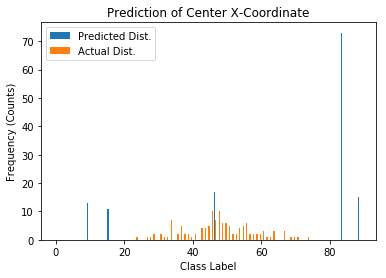

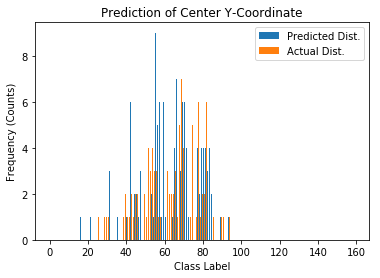

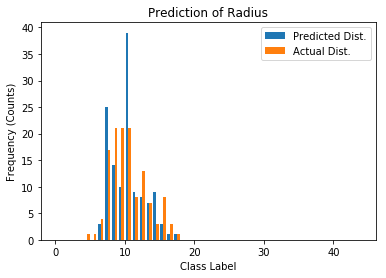

In [64]:
scores_x = model_x(X_val.reshape(X_val.shape[0], 3, X_val.shape[3], X_val.shape[4]))
scores_nparr_x = np.array(scores_x.data)
y_pred_val_x = np.argmax(scores_nparr_x, axis=1)
plt.hist([y_pred_val_x, y_val[:,0]], bins=range(90), label=['Predicted Dist.', 'Actual Dist.'])
plt.title('Prediction of Center X-Coordinate')
plt.xlabel('Class Label')
plt.ylabel('Frequency (Counts)')
plt.legend()
plt.show()

scores_y = model_y(X_val.reshape(X_val.shape[0], 3, X_val.shape[3], X_val.shape[4]))
scores_nparr_y = np.array(scores_y.data)
y_pred_val_y = np.argmax(scores_nparr_y, axis=1)
plt.hist([y_pred_val_y, y_val[:,1]], bins=range(160), label=['Predicted Dist.', 'Actual Dist.'])
plt.title('Prediction of Center Y-Coordinate')
plt.xlabel('Class Label')
plt.ylabel('Frequency (Counts)')
plt.legend()
plt.show()

scores_r = model_r(X_val.reshape(X_val.shape[0], 3, X_val.shape[3], X_val.shape[4]))
scores_nparr_r = np.array(scores_r.data)
y_pred_val_r = np.argmax(scores_nparr_r, axis=1)
plt.hist([y_pred_val_r, y_val[:,2]], bins=range(45), label=['Predicted Dist.', 'Actual Dist.'])
plt.title('Prediction of Radius')
plt.xlabel('Class Label')
plt.ylabel('Frequency (Counts)')
plt.legend()
plt.show()

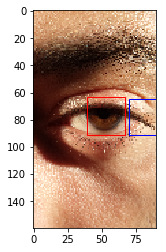

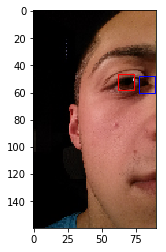

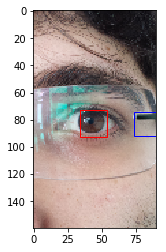

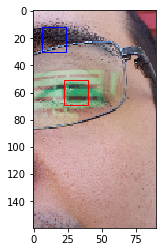

In [63]:
#im = np.array(Image.open('CASIA-Iris-Interval/001/L/S1001L01.jpg'), dtype=np.uint8)

sub = np.random.choice(X_val.shape[0], 4)
for idx in sub:
    fig, ax = plt.subplots(1)
    plt.imshow(X_val[idx,0,:,:,:].reshape(160,90,3))
    xc, yc, r = y_val[idx]
    
    xc_pred = np.argmax(np.array(model_x(X_val[idx]).data)) 
    yc_pred = np.argmax(np.array(model_y(X_val[idx]).data)) 
    r_pred = np.argmax(np.array(model_r(X_val[idx]).data))
    
    rect_true = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
    rect_pred = patches.Rectangle((xc_pred-r_pred,yc_pred-r_pred),2*r_pred,2*r_pred,
                                  linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect_true)
    ax.add_patch(rect_pred)
    plt.show()